In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
from itertools import chain

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K


In [2]:
img_width = 128
img_height = 128
img_channels = 3

train_path = 'U_NET/train/'
test_path = 'U_NET/validation/'

In [3]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [4]:
X_train = np.zeros((len(train_ids), 128, 128, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), 128, 128, 1), dtype=np.bool)

In [5]:

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    path = train_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((128, 128, 1), dtype=np.bool)
    
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (128, 128), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        Y_train[n] = mask 

100%|██████████| 670/670 [07:30<00:00,  1.49it/s]


In [6]:
X_test = np.zeros((len(test_ids), 128, 128, 3), dtype=np.uint8)
sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 65/65 [00:02<00:00, 23.45it/s]


In [7]:
X_train = X_train/255
X_test = X_test/255

In [24]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)


    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1
        false_positives = np.sum(matches, axis=0) == 0
        false_negatives = np.sum(matches, axis=1) == 0
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [25]:
def model():
    
    inputs = Input((128, 128, 3))
    
    x = inputs

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (x)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [my_iou_metric])
    
    return model

In [26]:
model = model()

W1228 21:34:48.940831 139913910433600 deprecation.py:323] From <ipython-input-24-a3fe61a0a9aa>:57: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [27]:
model_path = "model.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=10, 
                    callbacks=[earlystop, checkpoint])

Train on 603 samples, validate on 67 samples
Epoch 1/10
592/603 [============================>.] - ETA: 1s - loss: 0.4068 - my_iou_metric: 0.0441
Epoch 00001: val_loss improved from inf to 0.20122, saving model to model.h5
603/603 [==============================] - 70s 116ms/sample - loss: 0.4030 - my_iou_metric: 0.0488 - val_loss: 0.2012 - val_my_iou_metric: 0.2132
Epoch 2/10
592/603 [============================>.] - ETA: 1s - loss: 0.2216 - my_iou_metric: 0.2388
Epoch 00002: val_loss improved from 0.20122 to 0.16762, saving model to model.h5
603/603 [==============================] - 70s 116ms/sample - loss: 0.2207 - my_iou_metric: 0.2395 - val_loss: 0.1676 - val_my_iou_metric: 0.3291
Epoch 3/10
592/603 [============================>.] - ETA: 1s - loss: 0.1493 - my_iou_metric: 0.3482
Epoch 00003: val_loss improved from 0.16762 to 0.14643, saving model to model.h5
603/603 [==============================] - 71s 117ms/sample - loss: 0.1489 - my_iou_metric: 0.3503 - val_loss: 0.1464 - v

In [29]:
preds_test = model.predict(X_test)

NameError: name 'preds_val_t' is not defined

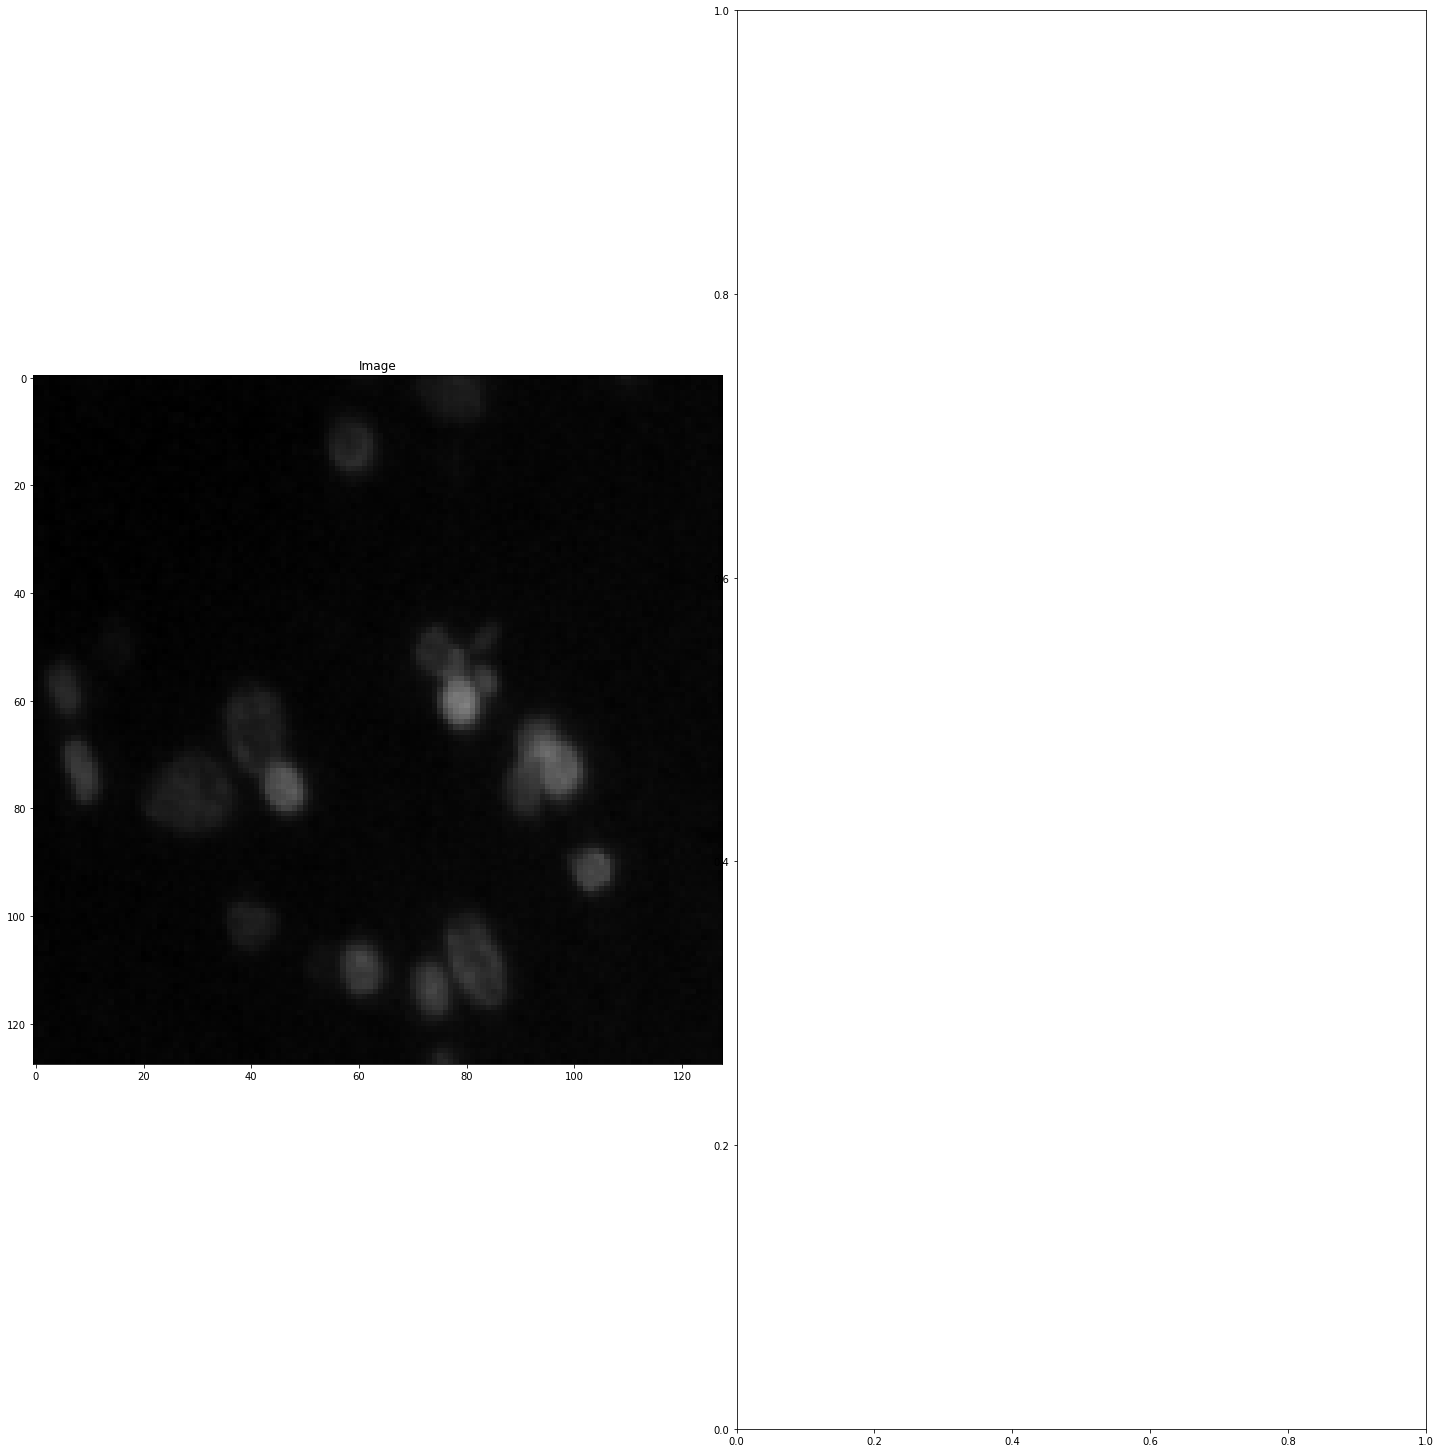

In [32]:
ix = random.randint(1, 10)
plt.figure(figsize=(20,20))

plt.subplot(121)
imshow(X_test[ix])
plt.title("Image")

plt.subplot(122)
ix = ix - 10
imshow(np.squeeze(preds__t[ix] > 0.5))
plt.title("Predictions")
plt.show()